In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tifffile as tf
import os
import pandas as pd
from scipy import ndimage

In [8]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)
unique = np.array([40, 120, 160, 200, 240], dtype=np.uint8)
colors = ['#117733', '#aa4499', '#332288', '#44aa99', '#88ccee', '#ddcc77']
thr = 40

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

rsrc = '../raw/'
src = '../proc/'
dst = '../proc/plots/'
time = '4pm'
rep = 7
pidx = 2

asrc = src + 'anchory/' + time + '_rep{}/'.format(rep)
psrc = src + 'prelim/' + time + '_rep{}/'.format(rep)

filenames = glob(psrc + 'plant_{:02d}/*.tif'.format(pidx))

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('_')[-1]
    num = int(num)
    nums[i] = num
anums = np.argsort(nums)

In [9]:
metafile = '{}{}_rep{}_plant_{:02d}.csv'.format(asrc, time, rep, pidx)
meta = pd.read_csv(metafile, header=None)
meta.index = nums[anums]

lenraw = meta.iloc[0,0]
tape = meta.iloc[:,2].values
peak = meta.iloc[:,3].values
buffx = meta.iloc[:,4].values
buffy = meta.iloc[:,5].values

plant = meta.iloc[:, 6:10].values.astype(int)
pss = [ np.s_[plant[i,0]:plant[i,1], plant[i,2]:plant[i,3]] for i in range(len(plant)) ]

ceros = meta.iloc[:, 10:14].values.astype(int)
css = [ np.s_[ceros[i, 0]:ceros[i,1], ceros[i,2]:ceros[i,3]] for i in range(len(ceros)) ]
coef = meta.iloc[:,15:].values

rawx = ceros[:, 2] + plant[:, 2] - peak + buffy
rawy = ceros[:, 0] + plant[:, 0] + buffx

xvals = np.arange(lenraw)
b0 = peak + coef[:, 0] - buffy
lines = b0.reshape(-1,1) + np.outer(coef[:,1], xvals)

line = [ lines[i][pss[i][0]] - plant[i,2] for i in range(len(pss)) ]
ll = [ line[i][np.arange(ceros[i,0], ceros[i,1])] - ceros[i,2] for i in range(len(ceros))]
xx = [ np.arange(ceros[i,1] - ceros[i,0]) for i in range(len(ceros)) ]

v0 = np.column_stack((coef[:,1], np.ones(len(coef))))
v = v0/(np.linalg.norm(v0, axis=1)).reshape(-1,1)
n = np.column_stack((-v[:,1], v[:,0]))
p = np.column_stack(([ll[i][0] for i in range(len(ll))], np.zeros(len(ll))))
b = np.sum(p*n, axis=1)

mint = np.min(tape)
stick = [ np.s_[buffx[i]:mint+buffx[i], peak[i]-buffy[i]:peak[i]+buffy[i]] for i in range(len(tape)) ]

In [10]:
df = pd.read_csv(psrc + '{}_rep{}_plant_{:02d}.csv'.format(time, rep, pidx))
df = df.iloc[np.argmax((df.pos_raw_1 != -100).values):, :]

tmin, tmax = df.iloc[0]['timestamp'], df.iloc[-1]['timestamp']

poscols = ['pos_sg_{}'.format(i+1) for i in range((df.shape[1]-1)//6)]
pos = df.loc[:, poscols].values
posmin, posmax = np.min(pos[pos > -100]), np.max(pos[pos > -100])

angcols = ['angle_sg_{}'.format(i+1) for i in range((df.shape[1]-1)//6)]
ang = df.loc[:, angcols].values
angmin, angmax = np.min(ang[pos > -100]), np.max(ang[pos > -100])

print(posmin, '\t', posmax, '\n', angmin, '\t', angmax, '\n', tmin, '\t', tmax, sep='')

print(df.shape)
df.head()

232.63347240994432	527.6123256453031
-61.04564169263021	59.68692908256402
289.0	902.0
(614, 13)


,timestamp,angle_raw_2,angle_interp_2,angle_sg_2,angle_raw_1,angle_interp_1,angle_sg_1,pos_raw_2,pos_interp_2,pos_sg_2,pos_raw_1,pos_interp_1,pos_sg_1
0,289,-100.0,-100.0,-100.0,55.256169,55.256169,55.144375,-100.0,-100.0,-100.0,531.500000,531.500000,527.612326
1,290,-100.0,-100.0,-100.0,54.303539,54.303539,54.098828,-100.0,-100.0,-100.0,525.947368,525.947368,523.736679
2,291,-100.0,-100.0,-100.0,54.860915,54.860915,52.634415,-100.0,-100.0,-100.0,520.461538,520.461538,518.883485
3,292,-100.0,-100.0,-100.0,54.314867,54.314867,50.942380,-100.0,-100.0,-100.0,512.500000,512.500000,512.807676
4,293,-100.0,-100.0,-100.0,48.655494,48.655494,48.898252,-100.0,-100.0,-100.0,505.500000,505.500000,506.111606


In [48]:
idx = 290
rawname = '{}{} Inc Rep {}/{} Inc Rep {} ({}).JPG'.format(rsrc, time, rep, time, rep, nums[anums[idx]])
print(rawname)
print(filenames[anums[idx]])
filename = dst + time + '_rep{}_plant_{:02d}_{:04d}'.format(rep,pidx,nums[anums[idx]])
print(filename)

raw = cv2.imread(rawname)
img = tf.imread(filenames[anums[idx]]) > 160
coords = np.asarray(np.nonzero(img))
off = len(line[idx]) - len(lines[idx, stick[idx][0]])
foo = df[df.timestamp <= nums[anums[idx]]]

coms = df[df.timestamp == nums[anums[idx]]]
if len(coms) > 0:
    comsy = mint - coms.iloc[0, [12, 9]].values
    angs = coms.iloc[0, [6,3]].values
    angs = np.tan(np.deg2rad(np.atleast_1d(angs[ comsy < mint] )))
    comsy = np.atleast_1d(comsy[comsy < mint])
linxx = lines[idx, stick[idx][0]] - peak[idx] + buffy[idx]
rawxx = xvals[stick[idx][0]] - buffx[idx]
dist = np.abs(coords[1]*n[idx, 0] + coords[0]*n[idx, 1] - b[idx])
mask = ((dist < thr-5) | (dist > thr+5)) & (coords[1] + rawx[idx] > 0) & (coords[1] + rawx[idx] < 2*buffy[idx]) & (coords[0]+rawy[idx] - off > 0)

../raw/4pm Inc Rep 7/4pm Inc Rep 7 (291).JPG
../proc/prelim/4pm_rep7/plant_02/4pm_rep07_0291.tif
../proc/plots/4pm_rep7_plant_02_0291


In [60]:
img1 = tf.imread(filenames[anums[idx]])//40
img1[img1 > 1] = 2
img1[img] += 2
print(img.shape)

(542, 196)


In [64]:
coms.iloc[0, [12, 9]].values

array([ 518.88348471, -100.        ])

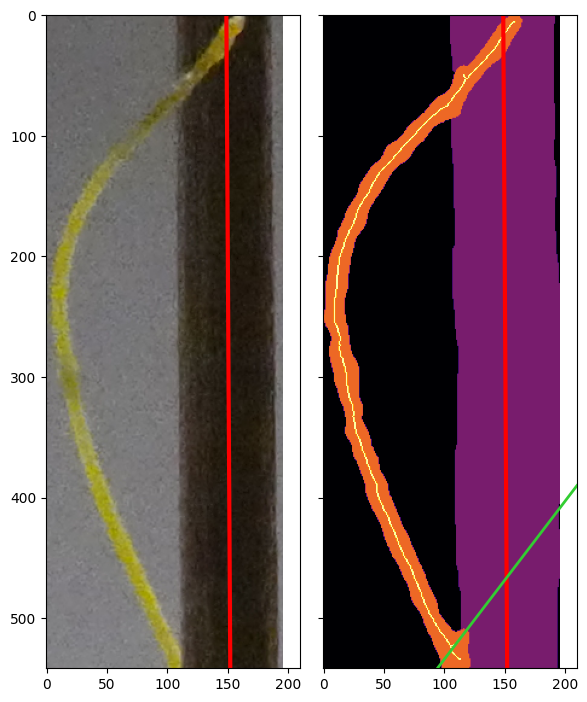

In [53]:
fs = 15
fig, ax = plt.subplots(1,2,figsize=(6,8), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(raw[pss[idx]][css[idx]][:,:,::-1], cmap='inferno', vmin=0, zorder = 2);
ax[1].imshow(img1, cmap='inferno', vmin=0, vmax=3, zorder = 2);

for i in range(len(coms)):
    ax[1].axline(xy1 = (linxx[comsy.astype(int)][i] , comsy[i]), slope = -angs[i], c='limegreen', alpha=1, lw=2, zorder=4+i)

for i in range(len(ax)):
    ax[i].plot(line[idx][np.arange(ceros[idx][0],ceros[idx][1])] - ceros[idx][2], range(ceros[idx][1]-ceros[idx][0]), color='red', lw=3);
    #ax[i].axis('off')

fig.tight_layout()

In [11]:
for idx in range(250, len(anums)):
#for idx in range(250, len(anums), 125):
    
    rawname = '{}{} Inc Rep {}/{} Inc Rep {} ({}).JPG'.format(rsrc, time, rep, time, rep, nums[anums[idx]])
    
    raw = cv2.imread(rawname)
    img = tf.imread(filenames[anums[idx]]) > 160
    coords = np.asarray(np.nonzero(img))
    off = len(line[idx]) - len(lines[idx, stick[idx][0]])
    foo = df[df.timestamp <= nums[anums[idx]]]
    
    coms = df[df.timestamp == nums[anums[idx]]]
    if len(coms) > 0:
        comsy = mint - coms.iloc[0, [12, 9]].values
        angs = coms.iloc[0, [6,3]].values
        angs = np.tan(np.deg2rad(np.atleast_1d(angs[ comsy < mint] )))
        comsy = np.atleast_1d(comsy[comsy < mint])
    linxx = lines[idx, stick[idx][0]] - peak[idx] + buffy[idx]
    rawxx = xvals[stick[idx][0]] - buffx[idx]
    dist = np.abs(coords[1]*n[idx, 0] + coords[0]*n[idx, 1] - b[idx])
    mask = ((dist < thr-5) | (dist > thr+5)) & (coords[1] + rawx[idx] > 0) & (coords[1] + rawx[idx] < 2*buffy[idx]) & (coords[0]+rawy[idx] - off > 0)
    
    fig = plt.figure(layout='constrained', figsize=(12,5))
    gs = GridSpec(2,6, figure=fig)
    ax0 = fig.add_subplot(gs[:,0])
    ax1 = fig.add_subplot(gs[:,1])
    ax2 = fig.add_subplot(gs[0,2:])
    ax3 = fig.add_subplot(gs[1,2:])
    
    ax = [ax0, ax1, ax2, ax3]
    
    ax[0].set_title('Raw', fontsize=fs)
    ax[1].set_title('Processed', fontsize=fs)
    
    for i in [0,1]:
        ax[i].imshow(raw[stick[idx]][:,:,::-1], zorder=1)
    
    ax[1].plot(linxx, rawxx, c=colors[0], lw=4, zorder=2)
    ax[1].scatter(coords[1,mask] + rawx[idx], coords[0,mask]+rawy[idx] - off, c=colors[4], s=20, zorder=3)
    ax[1].tick_params(labelleft = False)
        
    if len(coms) > 0:
        for i in range(len(comsy)):
            ax[1].axline(xy1 = (linxx[comsy.astype(int)][i] , comsy[i]), slope = -angs[i], c=colors[i+1], alpha=1, lw=2, zorder=4+i)
        ax[1].scatter(linxx[comsy.astype(int)] , comsy, c='w', s=100, marker='*', edgecolor='k', zorder=6)
        
        for i in range(len(comsy)):
            bar = foo[foo['pos_sg_{}'.format(i+1)] > 0]
            ax[2].plot(bar['timestamp'], bar['angle_sg_{}'.format(i+1)], c=colors[i+1], lw=3)
            ax[3].plot(bar['timestamp'], bar['pos_sg_{}'.format(i+1)], c=colors[i+1], lw=3)
    
    ax[2].axhline(0, c='gray')
    ax[2].scatter([tmin, tmax], [angmin, angmax], alpha=0)
    ax[3].scatter([tmin, tmax], [posmin, posmax], alpha=0)
    
    for j in [2,3]:
        ax[j].set_xticks(np.arange(225,901,112.5), ['{}h'.format(3*i) for i in range(2,9)])
    ax[2].tick_params(labelbottom = False)
    
    ax[3].set_xlabel('Time after inoculation', fontsize=fs)
    
    ax[2].set_ylabel('Angle wrt\nbase [$\circ$]', fontsize=fs)
    ax[3].set_ylabel('Height from\nbase [px]', fontsize=fs)
    
    for i in range(len(ax)):
        ax[i].tick_params(labelsize=fs-3)
    
    fig.suptitle('Inc @ {}, Repetition {}, Skewer {}'.format(time, rep, pidx), fontsize=fs+5);

    filename = dst + time + '_rep{}_plant_{:02d}_{:04d}'.format(rep,pidx,nums[anums[idx]])
    plt.savefig(filename + '.png', dpi=94, format='png', pil_kwargs={'optimize':True}, bbox_inches='tight')
    #plt.savefig(filename + '.jpg', dpi=100, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')
    plt.close()

In [10]:
filename = dst + time + '_rep{}_plant_{:02d}_{:04d}'.format(rep,pidx,nums[anums[idx]])
filename

'../proc/anim/4pm_rep7_plant_00/4pm_rep7_plant_00_0331'

In [ ]:
plt.imshow(v > 62, cmap='Greys_r');